# Style Transcoders

In [1]:
# Autoreloading makes development easier
%load_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as krs
import tensorflow_probability as tfp
import json
from sklearn.model_selection import train_test_split
from tools.audio_tools import read_audio, write_audio, play_audio
from tools.feature_tools import compute_mels, compute_imels, compute_mfcc, compute_imfcc, load_data, normalize_features, denormalize_features
from tools.constants import npy_classical_path, npy_jazz_path, models_path
from tools.plot_tools import make_figax, plot_history, plot_audio, plot_spectral_feature
from tools.tensorflow_tools import tune_hyperparameters, load_optimal_params

2023-11-26 19:48:06.911000: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 19:48:06.950041: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 19:48:06.950083: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 19:48:06.950114: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 19:48:06.957402: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 19:48:06.958066: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Data Loading

### Load Audio & Extract Features

In [3]:
n_samples = 5000
n_samples = min(n_samples, len(os.listdir(npy_classical_path)), len(os.listdir(npy_jazz_path)))
print(f"{n_samples = }")

X_c_raw = load_data(npy_classical_path, n_samples=n_samples)
X_j_raw = load_data(npy_jazz_path, n_samples=n_samples)

print(f"{X_c_raw.shape = }")
print(f"{X_j_raw.shape = }")

n_samples = 418
100 %
100 %
X_c_raw.shape = (418, 67, 128, 1)
X_j_raw.shape = (418, 67, 128, 1)


### Train - Validation - Test Split

In [4]:
# Fraction of data to keep apart for validation
test_size = round(0.1 * n_samples)
val_size = test_size
# Perform splits
X_c_raw_train, X_c_raw_test = train_test_split(X_c_raw, test_size=test_size)
X_c_raw_train, X_c_raw_val = train_test_split(X_c_raw_train, test_size=val_size)
X_j_raw_train, X_j_raw_test = train_test_split(X_j_raw, test_size=test_size)
X_j_raw_train, X_j_raw_val = train_test_split(X_j_raw_train, test_size=val_size)
# Verify split shapes
print(f"{X_c_raw_train.shape = }")
print(f"{X_c_raw_test.shape = }")
print(f"{X_c_raw_val.shape = }")
print(f"{X_j_raw_train.shape = }")
print(f"{X_j_raw_test.shape = }")
print(f"{X_j_raw_val.shape = }")

X_c_raw_train.shape = (334, 67, 128, 1)
X_c_raw_test.shape = (42, 67, 128, 1)
X_c_raw_val.shape = (42, 67, 128, 1)
X_j_raw_train.shape = (334, 67, 128, 1)
X_j_raw_test.shape = (42, 67, 128, 1)
X_j_raw_val.shape = (42, 67, 128, 1)


### Normalize Features

In [5]:
# Perform normalization
X_c_train, X_c_val, X_c_test = normalize_features(X_c_raw_train, X_raw_val=X_c_raw_val, X_raw_test=X_c_raw_test, name="classical")
X_j_train, X_j_val, X_j_test = normalize_features(X_j_raw_train, X_raw_val=X_j_raw_val, X_raw_test=X_j_raw_test, name="jazz")

print(f"{X_c_train.shape }")
print(f"{X_c_val.shape }")
print(f"{X_c_test.shape }")
print(f"{X_j_train.shape }")
print(f"{X_j_val.shape }")
print(f"{X_j_test.shape }")

(334, 67, 128, 1)
(42, 67, 128, 1)
(42, 67, 128, 1)
(334, 67, 128, 1)
(42, 67, 128, 1)
(42, 67, 128, 1)


In [6]:
input_shape = X_c_train.shape[1:]

print(f"{input_shape = }")

input_shape = (67, 128, 1)


## Style Transfer Models

### Test Script

In [7]:
# Test transcoder
def test_transcoder(transcoder, X_test=X_c_test, Y_test=X_j_test, plot_transforms=True):
    # Random picks
    print("Picking samples")
    X = np.expand_dims(X_test[np.random.choice(len(X_test))], axis=0)
    Y = np.expand_dims(Y_test[np.random.choice(len(Y_test))], axis=0)
    print(f"{X.shape = }")
    print(f"{Y.shape = }")
    
    # Transcode
    print("Performing transcode")
    Y_fake = transcoder.transcode(X, XtoY=True)
    X_fake = transcoder.transcode(Y, XtoY=False)
    
    # Reconstruct raw spectra
    print("Denormalizing")
    X_raw = denormalize_features(X, name="classical")
    X_raw_fake = denormalize_features(X_fake, name="classical")
    Y_raw = denormalize_features(Y, name="jazz")
    Y_raw_fake = denormalize_features(Y_fake, name="jazz")
    
    # Plot raw spectra
    if plot_transforms:
        print("Plotting transforms")
        fig, ax = plot_spectral_feature(X_raw)
        ax.set_title("Classical Spectrum")
        fig, ax = plot_spectral_feature(Y_raw)
        ax.set_title("Jazz Spectrum")
        fig, ax = plot_spectral_feature(X_raw_fake)
        ax.set_title(r"Jazz $\rightarrow$ Classical Spectrum")
        fig, ax = plot_spectral_feature(Y_raw_fake)
        ax.set_title(r"Classical $\rightarrow$ Jazz Spectrum")
        plt.show()
    
    # Reconstruct audio
    print("Reconstructing audio")
    sX = np.squeeze(compute_imels(np.squeeze(X_raw)))
    sX_fake = np.squeeze(compute_imels(np.squeeze(X_raw_fake)))
    sY = np.squeeze(compute_imels(np.squeeze(Y_raw)))
    sY_fake = np.squeeze(compute_imels(np.squeeze(Y_raw_fake)))
    
    # Play audio
    print("Classical audio")
    player = play_audio(sX)
    print("Jazz audio")
    player = play_audio(sY)
    print("Jazz to Classical audio")
    player = play_audio(sX_fake)
    print("Classical to Jazz audio")
    player = play_audio(sY_fake)    

### Convolutional Style Transfer

In [9]:
from models.transcoders import Conv2DTranscoder

In [23]:
default_params = {
    "feature_shape": input_shape,
    "compression": 4,
    "kernel_size": 5,
    "conv_depth": 2,
    "input_chans_multiplier": 1,
    "skip_connection": False,
    "pooling_type": "average",
    "h_reg": 1e-1,
    "kl_reg": 0.,
}
results_path = os.path.join("./results/ConvolutionalTranscoder")
os.makedirs(results_path, exist_ok=True)

In [24]:
# Construct model
transcoder = Conv2DTranscoder(**default_params)
transcoder.compile(optimizer="adam")

In [25]:
# Train model
loss_key = "val_r_loss"
earlystopping = krs.callbacks.EarlyStopping(monitor=loss_key, patience=5, min_delta=1e-6)
history = transcoder.fit(X_c_train, X_j_train, epochs=250, shuffle=True, callbacks=[earlystopping], validation_data=(X_c_val, X_j_val), verbose=1)

Epoch 1/250
125/125 [==============================] - 10s 28ms/step - loss: 0.1827 - r_loss: 0.1819 - h_loss: 0.0083 - kl_loss: 0.0012 - val_loss: 0.1679 - val_r_loss: 0.1669 - val_h_loss: 0.0100 - val_kl_loss: 0.0013
Epoch 2/250
125/125 [==============================] - 3s 20ms/step - loss: 0.1572 - r_loss: 0.1555 - h_loss: 0.0172 - kl_loss: 0.0035 - val_loss: 0.1423 - val_r_loss: 0.1396 - val_h_loss: 0.0270 - val_kl_loss: 0.0088
Epoch 3/250
125/125 [==============================] - 3s 20ms/step - loss: 0.1357 - r_loss: 0.1332 - h_loss: 0.0241 - kl_loss: 0.0079 - val_loss: 0.1291 - val_r_loss: 0.1268 - val_h_loss: 0.0227 - val_kl_loss: 0.0056
Epoch 4/250
125/125 [==============================] - 3s 20ms/step - loss: 0.1245 - r_loss: 0.1224 - h_loss: 0.0210 - kl_loss: 0.0053 - val_loss: 0.1185 - val_r_loss: 0.1165 - val_h_loss: 0.0200 - val_kl_loss: 0.0036
Epoch 5/250
125/125 [==============================] - 3s 20ms/step - loss: 0.1136 - r_loss: 0.1115 - h_loss: 0.0203 - kl_loss:

125/125 [==============================] - 3s 20ms/step - loss: 0.0777 - r_loss: 0.0762 - h_loss: 0.0152 - kl_loss: 5.0521e-04 - val_loss: 0.0772 - val_r_loss: 0.0757 - val_h_loss: 0.0149 - val_kl_loss: 3.8373e-04
Epoch 38/250
125/125 [==============================] - 3s 20ms/step - loss: 0.0770 - r_loss: 0.0756 - h_loss: 0.0148 - kl_loss: 4.9941e-04 - val_loss: 0.0768 - val_r_loss: 0.0755 - val_h_loss: 0.0139 - val_kl_loss: 3.9567e-04
Epoch 39/250
125/125 [==============================] - 3s 20ms/step - loss: 0.0771 - r_loss: 0.0756 - h_loss: 0.0146 - kl_loss: 5.2765e-04 - val_loss: 0.0769 - val_r_loss: 0.0755 - val_h_loss: 0.0145 - val_kl_loss: 3.7713e-04
Epoch 40/250
125/125 [==============================] - 3s 20ms/step - loss: 0.0767 - r_loss: 0.0752 - h_loss: 0.0149 - kl_loss: 5.1275e-04 - val_loss: 0.0767 - val_r_loss: 0.0753 - val_h_loss: 0.0143 - val_kl_loss: 3.5812e-04
Epoch 41/250
125/125 [==============================] - 3s 21ms/step - loss: 0.0765 - r_loss: 0.0750 - h_

125/125 [==============================] - 3s 20ms/step - loss: 0.0723 - r_loss: 0.0711 - h_loss: 0.0118 - kl_loss: 3.1887e-04 - val_loss: 0.0728 - val_r_loss: 0.0716 - val_h_loss: 0.0114 - val_kl_loss: 2.3280e-04
Epoch 74/250
125/125 [==============================] - 3s 21ms/step - loss: 0.0724 - r_loss: 0.0712 - h_loss: 0.0120 - kl_loss: 3.0745e-04 - val_loss: 0.0720 - val_r_loss: 0.0709 - val_h_loss: 0.0115 - val_kl_loss: 2.5518e-04
Epoch 75/250
125/125 [==============================] - 3s 21ms/step - loss: 0.0723 - r_loss: 0.0712 - h_loss: 0.0117 - kl_loss: 2.9236e-04 - val_loss: 0.0732 - val_r_loss: 0.0720 - val_h_loss: 0.0124 - val_kl_loss: 2.6907e-04
Epoch 76/250
125/125 [==============================] - 3s 20ms/step - loss: 0.0722 - r_loss: 0.0711 - h_loss: 0.0118 - kl_loss: 2.9292e-04 - val_loss: 0.0718 - val_r_loss: 0.0707 - val_h_loss: 0.0115 - val_kl_loss: 2.3428e-04
Epoch 77/250
125/125 [==============================] - 3s 20ms/step - loss: 0.0720 - r_loss: 0.0708 - h_

Picking samples
X.shape = (1, 67, 128, 1)
Y.shape = (1, 67, 128, 1)
Performing transcode
Denormalizing
Plotting transforms


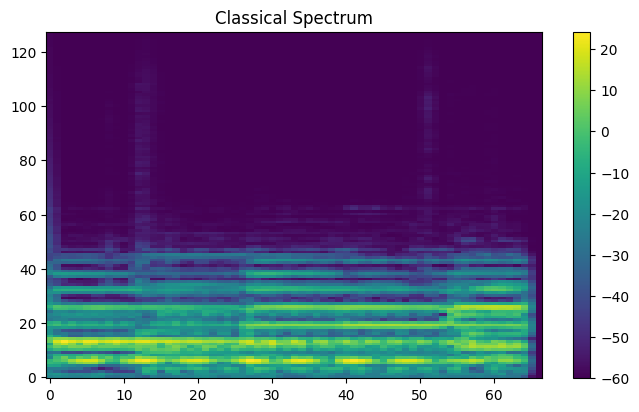

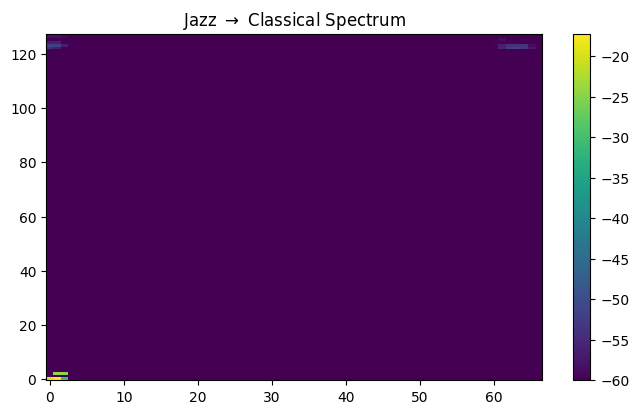

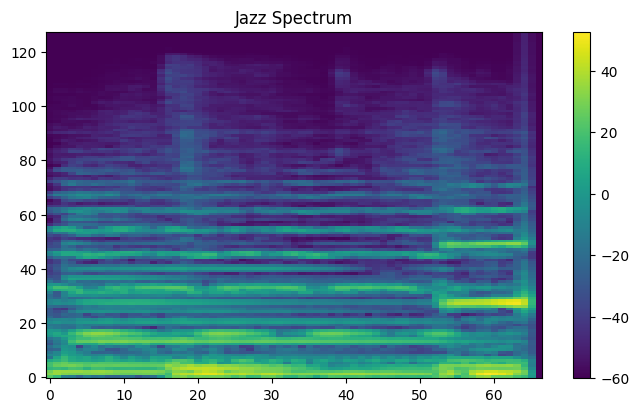

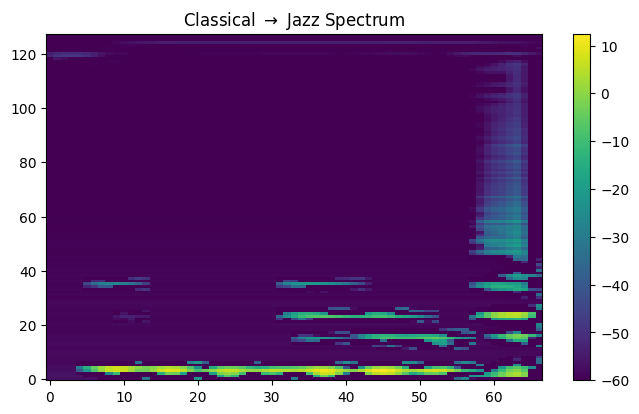

Reconstructing audio
Classical audio


Jazz to Classical audio


Jazz audio


Classical to Jazz audio


In [32]:
# Test model
test_transcoder(transcoder)

In [30]:
# Save model
transcoder.save_weights(os.path.join(results_path, "model"))

In [31]:
# Load model
transcoder = Conv2DTranscoder(**default_params)
transcoder.load_weights(os.path.join(results_path, "model"))

### Variational Style Transfer

In [33]:
from models.transcoders import VariationalTranscoder

In [60]:
default_params = {
    "feature_shape": input_shape,
    "compression": 4,
    "kernel_size": 5,
    "conv_depth": 2,
    "input_chans_multiplier": 1,
    "skip_connection": False,
    "pooling_type": "average",
    "h_reg": 1e-5,
    "kl_reg": 1e-3,
}
results_path = os.path.join("./results/VariationalTranscoder")
os.makedirs(results_path, exist_ok=True)

In [61]:
# Construct model
transcoder = VariationalTranscoder(**default_params)
transcoder.compile(optimizer="adam")

In [62]:
# Train model
loss_key = "val_r_loss"
earlystopping = krs.callbacks.EarlyStopping(monitor=loss_key, patience=5, min_delta=1e-6)
history = transcoder.fit(X_c_train, X_j_train, epochs=250, callbacks=[earlystopping], shuffle=True, validation_data=(X_c_val, X_j_val), verbose=1)

Epoch 1/250
125/125 [==============================] - 11s 35ms/step - loss: 0.2076 - r_loss: 0.2076 - h_loss: 0.0464 - kl_loss: 0.0097 - val_loss: 0.2054 - val_r_loss: 0.2054 - val_h_loss: 0.0403 - val_kl_loss: 0.0290
Epoch 2/250
125/125 [==============================] - 3s 26ms/step - loss: 0.2052 - r_loss: 0.2052 - h_loss: 0.0501 - kl_loss: 0.0078 - val_loss: 0.2054 - val_r_loss: 0.2054 - val_h_loss: 0.0570 - val_kl_loss: 0.0033
Epoch 3/250
125/125 [==============================] - 3s 26ms/step - loss: 0.2051 - r_loss: 0.2051 - h_loss: 0.1048 - kl_loss: 0.0130 - val_loss: 0.2052 - val_r_loss: 0.2051 - val_h_loss: 0.2325 - val_kl_loss: 0.0794
Epoch 4/250
125/125 [==============================] - 3s 26ms/step - loss: 0.1895 - r_loss: 0.1890 - h_loss: 0.5609 - kl_loss: 0.5395 - val_loss: 0.1792 - val_r_loss: 0.1786 - val_h_loss: 0.6185 - val_kl_loss: 0.6727
Epoch 5/250
125/125 [==============================] - 3s 26ms/step - loss: 0.1718 - r_loss: 0.1707 - h_loss: 0.7409 - kl_loss:

125/125 [==============================] - 3s 26ms/step - loss: 0.0937 - r_loss: 0.0885 - h_loss: 1.1326 - kl_loss: 5.2060 - val_loss: 0.0936 - val_r_loss: 0.0887 - val_h_loss: 1.0931 - val_kl_loss: 4.9773
Epoch 39/250
125/125 [==============================] - 3s 27ms/step - loss: 0.0936 - r_loss: 0.0884 - h_loss: 1.1293 - kl_loss: 5.2053 - val_loss: 0.0938 - val_r_loss: 0.0885 - val_h_loss: 1.1439 - val_kl_loss: 5.3236
Epoch 40/250
125/125 [==============================] - 3s 26ms/step - loss: 0.0934 - r_loss: 0.0881 - h_loss: 1.1323 - kl_loss: 5.2516 - val_loss: 0.0938 - val_r_loss: 0.0886 - val_h_loss: 1.1236 - val_kl_loss: 5.1295
Epoch 41/250
125/125 [==============================] - 3s 26ms/step - loss: 0.0932 - r_loss: 0.0879 - h_loss: 1.1260 - kl_loss: 5.2452 - val_loss: 0.0928 - val_r_loss: 0.0878 - val_h_loss: 1.1084 - val_kl_loss: 5.0479
Epoch 42/250
125/125 [==============================] - 3s 26ms/step - loss: 0.0930 - r_loss: 0.0878 - h_loss: 1.1326 - kl_loss: 5.2436 -

125/125 [==============================] - 3s 26ms/step - loss: 0.0888 - r_loss: 0.0833 - h_loss: 1.1847 - kl_loss: 5.5130 - val_loss: 0.0886 - val_r_loss: 0.0834 - val_h_loss: 1.1544 - val_kl_loss: 5.1790
Epoch 76/250
125/125 [==============================] - 3s 27ms/step - loss: 0.0889 - r_loss: 0.0834 - h_loss: 1.1899 - kl_loss: 5.5376 - val_loss: 0.0884 - val_r_loss: 0.0831 - val_h_loss: 1.1997 - val_kl_loss: 5.3578
Epoch 77/250
125/125 [==============================] - 3s 26ms/step - loss: 0.0886 - r_loss: 0.0831 - h_loss: 1.1938 - kl_loss: 5.4899 - val_loss: 0.0884 - val_r_loss: 0.0830 - val_h_loss: 1.1817 - val_kl_loss: 5.3753
Epoch 78/250
125/125 [==============================] - 3s 26ms/step - loss: 0.0885 - r_loss: 0.0830 - h_loss: 1.1880 - kl_loss: 5.5372 - val_loss: 0.0887 - val_r_loss: 0.0835 - val_h_loss: 1.1834 - val_kl_loss: 5.2298
Epoch 79/250
125/125 [==============================] - 3s 26ms/step - loss: 0.0885 - r_loss: 0.0829 - h_loss: 1.1940 - kl_loss: 5.5373 -

125/125 [==============================] - 3s 26ms/step - loss: 0.0869 - r_loss: 0.0813 - h_loss: 1.2149 - kl_loss: 5.6319 - val_loss: 0.0868 - val_r_loss: 0.0813 - val_h_loss: 1.2226 - val_kl_loss: 5.4825
Epoch 113/250
125/125 [==============================] - 3s 26ms/step - loss: 0.0868 - r_loss: 0.0811 - h_loss: 1.2239 - kl_loss: 5.6593 - val_loss: 0.0866 - val_r_loss: 0.0811 - val_h_loss: 1.2220 - val_kl_loss: 5.5625
Epoch 114/250
125/125 [==============================] - 3s 26ms/step - loss: 0.0867 - r_loss: 0.0810 - h_loss: 1.2236 - kl_loss: 5.7010 - val_loss: 0.0872 - val_r_loss: 0.0819 - val_h_loss: 1.2320 - val_kl_loss: 5.3198
Epoch 115/250
125/125 [==============================] - 3s 26ms/step - loss: 0.0867 - r_loss: 0.0810 - h_loss: 1.2176 - kl_loss: 5.6779 - val_loss: 0.0866 - val_r_loss: 0.0812 - val_h_loss: 1.1989 - val_kl_loss: 5.3541
Epoch 116/250
125/125 [==============================] - 3s 26ms/step - loss: 0.0866 - r_loss: 0.0809 - h_loss: 1.2252 - kl_loss: 5.69

Picking samples
X.shape = (1, 67, 128, 1)
Y.shape = (1, 67, 128, 1)
Performing transcode
Denormalizing
Plotting transforms


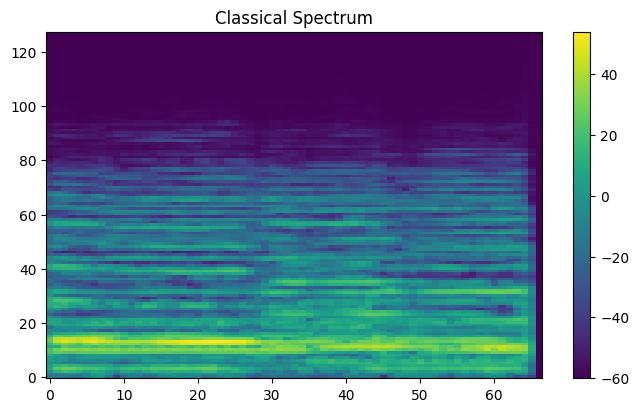

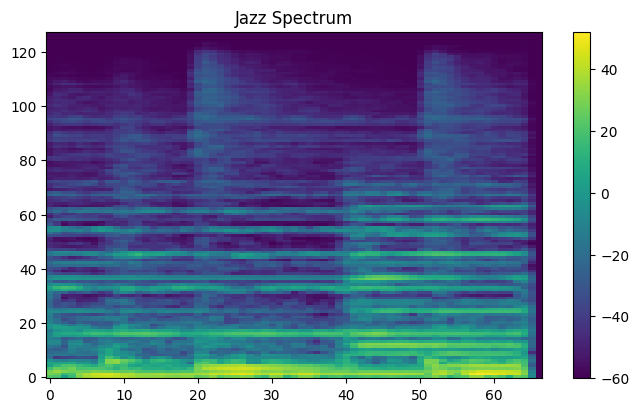

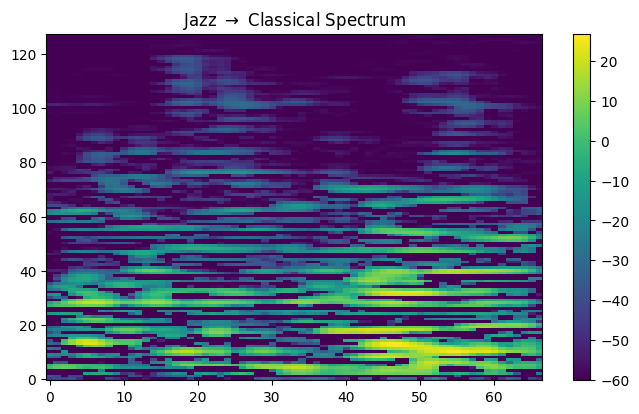

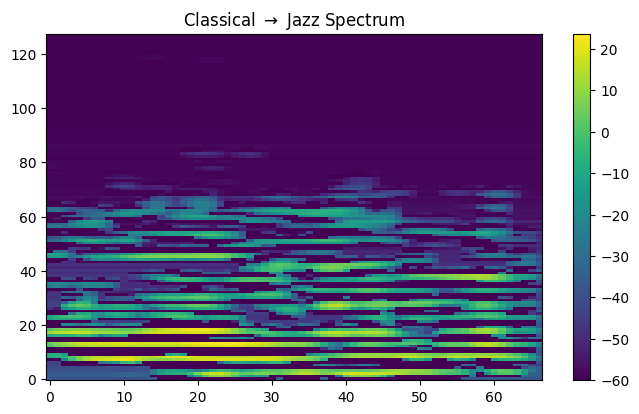

Reconstructing audio
Classical audio


Jazz audio


Jazz to Classical audio


Classical to Jazz audio


In [68]:
# Test transcoder
test_transcoder(transcoder)

In [65]:
# Save transcoder
transcoder.save_weights(os.path.join(results_path, "model"))

In [75]:
# Load transcoder
transcoder = VariationalTranscoder(**default_params)
transcoder.load_weights(os.path.join(results_path, "model"))

### GAN Style Transfer

In [8]:
from models.transcoders import GANTranscoder, GANDiscriminators
from models.layers import GAN

In [9]:
def create_gan_model(**params):
    # Split generator & discriminator params
    g_params = {}
    d_params = {}
    for key, value in params.items():
        if key[:2] == "g_":
            # Generator param
            g_params[key[2:]] = value
        elif key[:2] == "d_":
            # Discriminator param
            d_params[key[2:]] = value
        else:
            # Shared param
            g_params[key] = value
            d_params[key] = value
    generator = GANTranscoder(**g_params)
    discriminator = GANDiscriminators(**d_params)
    gan = GAN(generator, discriminator)
    return gan

In [49]:
default_params = {
    "feature_shape": input_shape,
    "g_compression": 4,
    "g_kernel_size": 5,
    "g_conv_depth": 2,
    "g_input_chans_multiplier": 1,
    "g_skip_connection": False,
    "g_pooling_type": "average",
    "g_gan_reg": 0.02,
    "g_c_reg": 0.01,
    "g_s_reg": 0.05,
    "g_concatentate": False,
    "g_hidden_activation": "sigmoid",
    "g_use_fake_style": False,
    "d_mlp_layers": 2,
    "d_conv_compression": 8,
    "d_conv_kernel_size": 3,
    "d_conv_pooling_type": "max",
}

compile_kwargs={
    "g_optimizer": "adam",
    "d_optimizer": "adam",
}

results_path = os.path.join("./results/GANTranscoder")
os.makedirs(results_path, exist_ok=True)

In [50]:
# Build model
gan = create_gan_model(**default_params)
gan.compile(**compile_kwargs)

In [51]:
# Train model
loss_key = "val_r_loss"
earlystopping = krs.callbacks.EarlyStopping(monitor=loss_key, patience=5, min_delta=1e-6)
history = gan.fit(X_c_train, X_j_train, epochs=250, shuffle=True, callbacks=[earlystopping], verbose=1, validation_data=(X_c_val, X_j_val))

Epoch 1/250
125/125 [==============================] - 15s 43ms/step - loss: 0.2493 - r_loss: 0.1913 - gan_loss: 2.8814 - c_loss: 0.0359 - s_loss: 9.7651e-05 - d_loss: 0.1230 - val_loss: 0.2524 - val_r_loss: 0.1817 - val_gan_loss: 3.4983 - val_c_loss: 0.0699 - val_s_loss: 0.0000e+00 - val_d_loss: 0.0594
Epoch 2/250
125/125 [==============================] - 4s 29ms/step - loss: 0.2427 - r_loss: 0.1789 - gan_loss: 3.1413 - c_loss: 0.0900 - s_loss: 1.8335e-07 - d_loss: 0.0313 - val_loss: 0.2005 - val_r_loss: 0.1796 - val_gan_loss: 0.9859 - val_c_loss: 0.1204 - val_s_loss: 1.2514e-05 - val_d_loss: 0.0204
Epoch 3/250
125/125 [==============================] - 4s 29ms/step - loss: 0.1851 - r_loss: 0.1638 - gan_loss: 1.0141 - c_loss: 0.0959 - s_loss: 0.0024 - d_loss: 0.0112 - val_loss: 0.1653 - val_r_loss: 0.1448 - val_gan_loss: 0.9622 - val_c_loss: 0.0957 - val_s_loss: 0.0064 - val_d_loss: 0.0049
Epoch 4/250
125/125 [==============================] - 4s 29ms/step - loss: 0.1562 - r_loss: 0.

125/125 [==============================] - 4s 29ms/step - loss: 0.1028 - r_loss: 0.0847 - gan_loss: 0.7875 - c_loss: 0.1813 - s_loss: 0.0103 - d_loss: 5.7735e-04 - val_loss: 0.1025 - val_r_loss: 0.0839 - val_gan_loss: 0.8345 - val_c_loss: 0.1459 - val_s_loss: 0.0090 - val_d_loss: 6.1592e-04
Epoch 29/250
125/125 [==============================] - 4s 29ms/step - loss: 0.1010 - r_loss: 0.0837 - gan_loss: 0.7680 - c_loss: 0.1509 - s_loss: 0.0090 - d_loss: 5.7316e-04 - val_loss: 0.1007 - val_r_loss: 0.0842 - val_gan_loss: 0.7181 - val_c_loss: 0.1589 - val_s_loss: 0.0106 - val_d_loss: 7.2041e-04
Epoch 30/250
 95/125 [=====================>........] - ETA: 0s - loss: 0.0994 - r_loss: 0.0834 - gan_loss: 0.6932 - c_loss: 0.1627 - s_loss: 0.0096 - d_loss: 4.0534e-04

KeyboardInterrupt: 

Picking samples
X.shape = (1, 67, 128, 1)
Y.shape = (1, 67, 128, 1)
Performing transcode
Denormalizing
Plotting transforms


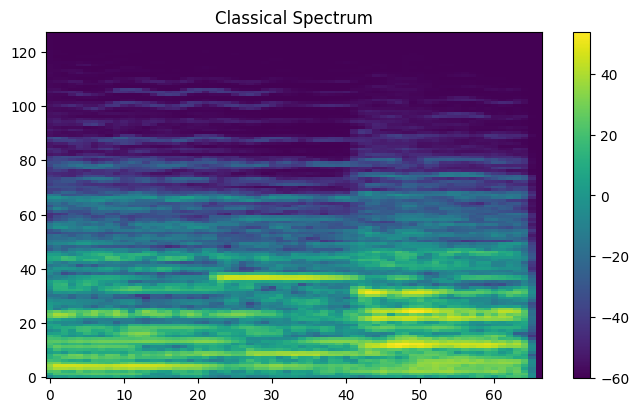

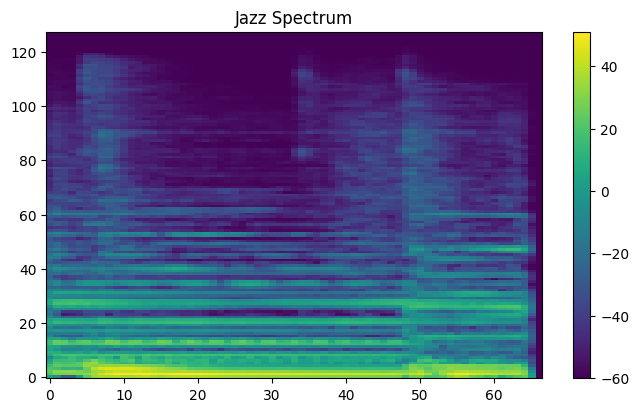

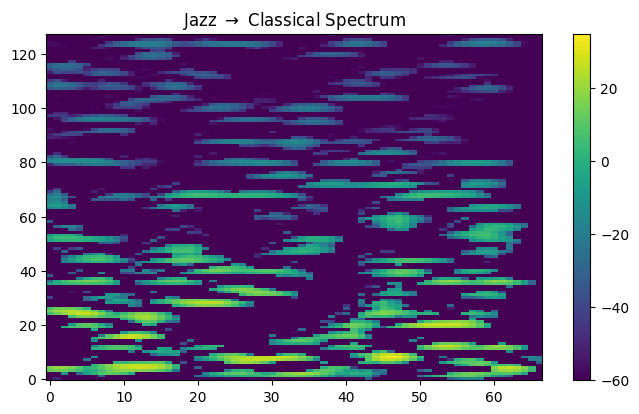

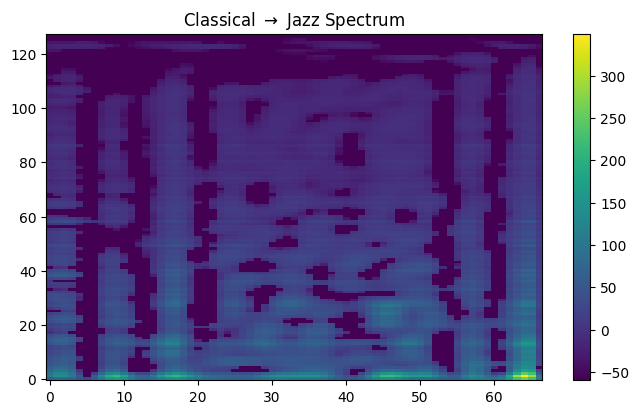

Reconstructing audio
Classical audio


Jazz audio


Jazz to Classical audio


Classical to Jazz audio


In [55]:
# Test model
test_transcoder(gan.generator)

In [ ]:
# Save transcoder
gan.generator.save_weights(os.path.join(results_path, "model"))

In [ ]:
# Load transcoder
gan = create_gan_model(**default_params)
gan.generator.load_weights(os.path.join(results_path, "model"))

### MUNIT Style Transfer

In [8]:
from models.transcoders import GANTranscoder, GANDiscriminators
from models.layers import GAN

In [9]:
def create_gan_model(**params):
    # Split generator & discriminator params
    g_params = {}
    d_params = {}
    for key, value in params.items():
        if key[:2] == "g_":
            # Generator param
            g_params[key[2:]] = value
        elif key[:2] == "d_":
            # Discriminator param
            d_params[key[2:]] = value
        else:
            # Shared param
            g_params[key] = value
            d_params[key] = value
    generator = GANTranscoder(**g_params)
    discriminator = GANDiscriminators(**d_params)
    gan = GAN(generator, discriminator)
    return gan

In [16]:
default_params = {
    "feature_shape": input_shape,
    "g_compression": 4,
    "g_kernel_size": 5,
    "g_conv_depth": 2,
    "g_input_chans_multiplier": 1,
    "g_skip_connection": False,
    "g_pooling_type": "average",
    "g_gan_reg": 0.02,
    "g_c_reg": 0.01,
    "g_s_reg": 0.05,
    "g_use_fake_style": False,
    "g_is_munit": True,
    "g_style_dim": 8,
    "g_adain_momentum": 0.1,
    "g_adain_epsilon": 1e-5,
    "d_mlp_layers": 2,
    "d_conv_compression": 8,
    "d_conv_kernel_size": 3,
    "d_conv_pooling_type": "max",
}

compile_kwargs={
    "g_optimizer": "adam",
    "d_optimizer": "adam",
}

results_path = os.path.join("./results/MUNITTranscoder")
os.makedirs(results_path, exist_ok=True)

In [17]:
# Build model
gan = create_gan_model(**default_params)
gan.compile(**compile_kwargs)

In [18]:
# Train model
loss_key = "val_r_loss"
earlystopping = krs.callbacks.EarlyStopping(monitor=loss_key, patience=5, min_delta=1e-6)
history = gan.fit(X_c_train, X_j_train, epochs=250, shuffle=True, callbacks=[earlystopping], verbose=1, validation_data=(X_c_val, X_j_val))

Epoch 1/250
11/11 [==============================] - 21s 880ms/step - loss: 0.3011 - r_loss: 0.2378 - gan_loss: 3.1549 - c_loss: 0.0171 - s_loss: 7.8871e-04 - d_loss: 0.2371 - val_loss: 0.2704 - val_r_loss: 0.2149 - val_gan_loss: 2.7672 - val_c_loss: 0.0224 - val_s_loss: 8.1495e-05 - val_d_loss: 0.1465
Epoch 2/250
11/11 [==============================] - 7s 651ms/step - loss: 0.3107 - r_loss: 0.2338 - gan_loss: 3.8318 - c_loss: 0.0309 - s_loss: 5.8912e-05 - d_loss: 0.1447 - val_loss: 0.2814 - val_r_loss: 0.2123 - val_gan_loss: 3.4358 - val_c_loss: 0.0355 - val_s_loss: 4.9501e-05 - val_d_loss: 0.0968
Epoch 3/250
 6/11 [===============>..............] - ETA: 3s - loss: 0.2974 - r_loss: 0.2326 - gan_loss: 3.2177 - c_loss: 0.0480 - s_loss: 4.2185e-05 - d_loss: 0.2274

KeyboardInterrupt: 

In [ ]:
# Test model
test_transcoder(gan.generator)

In [ ]:
# Save transcoder
gan.generator.save_weights(os.path.join(results_path, "model"))

In [ ]:
# Load transcoder
gan = create_gan_model(**default_params)
gan.generator.load_weights(os.path.join(results_path, "model"))